<a href="https://colab.research.google.com/github/nana881023/Financial_Big_Data_Analysis/blob/main/Week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 作業1：使用 TensorFlow 或 PyTorch 實作類神經網路模型預測股票價格
- （TensorFlow 使用 Dense layer；PyTorch 使用 Linear layer）。
- 說明：使用收盤價或技術指標預測，預測N日後的股價。



- 下載2330從2024.1.1到今天的資料
- 要輸出成表格
- 包含日期、開、高、低、收、量

In [1]:
# 安裝必要的套件，yfinance 用於下載股票資料，statsmodels 用於建立 ARIMA 模型
!pip install yfinance statsmodels matplotlib  # 安裝 yfinance、statsmodels、matplotlib 套件

- 導入套件

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


- 載入資料

In [4]:
# 股票參數設定
stock_id = "2330.TW"
start_date = "2024-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

# 下載股票資料
data = yf.download(stock_id, start=start_date, end=end_date)
print("Data shape:", data.shape)
print("\nFirst 5 rows of data:")
print(data.head())

[*********************100%***********************]  1 of 1 completed

Data shape: (196, 6)

First 5 rows of data:
Price                       Adj Close   Close    High     Low    Open  \
Ticker                        2330.TW 2330.TW 2330.TW 2330.TW 2330.TW   
Date                                                                    
2024-01-02 00:00:00+00:00  585.360962   593.0   593.0   589.0   590.0   
2024-01-03 00:00:00+00:00  570.554199   578.0   585.0   576.0   584.0   
2024-01-04 00:00:00+00:00  572.528442   580.0   581.0   577.0   580.0   
2024-01-05 00:00:00+00:00  568.579956   576.0   580.0   574.0   578.0   
2024-01-08 00:00:00+00:00  575.489746   583.0   585.0   579.0   582.0   

Price                        Volume  
Ticker                      2330.TW  
Date                                 
2024-01-02 00:00:00+00:00  26059058  
2024-01-03 00:00:00+00:00  37106763  
2024-01-04 00:00:00+00:00  15309129  
2024-01-05 00:00:00+00:00  18158971  
2024-01-08 00:00:00+00:00  17761275  


- 資料預處理

In [5]:
# 設定預測天數
prediction_days = 5

# 只使用收盤價
close_data = data[['Close']].values

# 資料標準化
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_data)

# 創建訓練數據
X = []
y = []

for i in range(len(scaled_data) - prediction_days):
    X.append(scaled_data[i:i+prediction_days])
    y.append(scaled_data[i + prediction_days])

X = np.array(X)
y = np.array(y)

# 分割訓練集和測試集 (80-20分割)
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# 轉換為PyTorch張量
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)


Training set size: 152
Testing set size: 39


- 定義模型

In [8]:
class StockPredictor(nn.Module):
  def __init__(self, input_dim):
    super(StockPredictor, self).__init__()
    self.layer1 = nn.Linear(input_dim, 64)
    self.layer2 = nn.Linear(64, 32)
    self.layer3 = nn.Linear(32, 1)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    # 確保輸入張量的形狀正確
    x = x.view(x.size(0), -1)  # 展平輸入數據
    x = self.relu(self.layer1(x))
    x = self.dropout(x)
    x = self.relu(self.layer2(x))
    x = self.dropout(x)
    x = self.layer3(x)
    return x

# 初始化模型和訓練參數
model = StockPredictor(prediction_days)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

- 訓練模型

In [9]:
num_epochs = 100
batch_size = 32
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)

# 用於儲存訓練過程中的損失值
train_losses = []
for epoch in range(num_epochs):
  model.train()
  total_loss = 0
  for batch_X, batch_y in train_loader:
    optimizer.zero_grad()
    outputs = model(batch_X)
    loss = criterion(outputs, batch_y)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  train_losses.append(avg_loss)

  if (epoch + 1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [10/100], Loss: 0.0199
Epoch [20/100], Loss: 0.0115
Epoch [30/100], Loss: 0.0094
Epoch [40/100], Loss: 0.0104
Epoch [50/100], Loss: 0.0108
Epoch [60/100], Loss: 0.0086
Epoch [70/100], Loss: 0.0086
Epoch [80/100], Loss: 0.0072
Epoch [90/100], Loss: 0.0085
Epoch [100/100], Loss: 0.0071


- 預測和視覺化

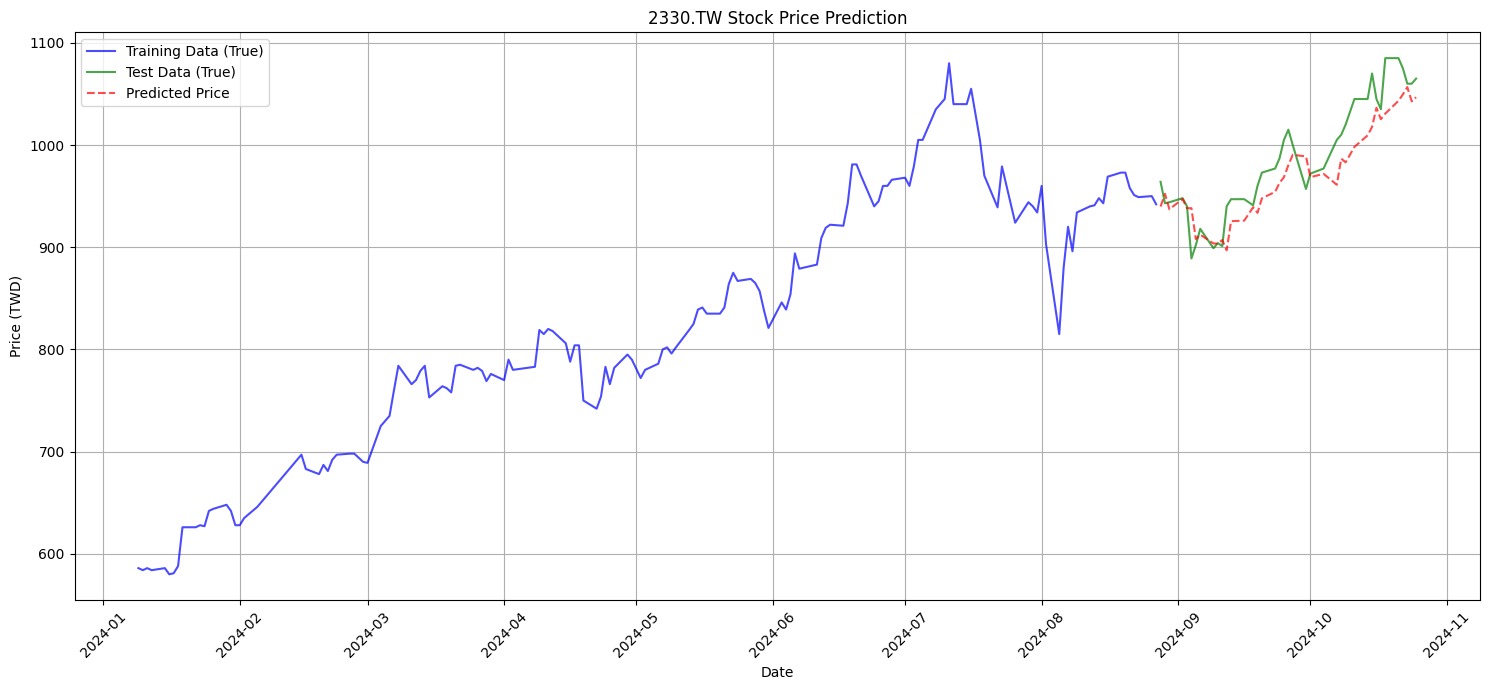

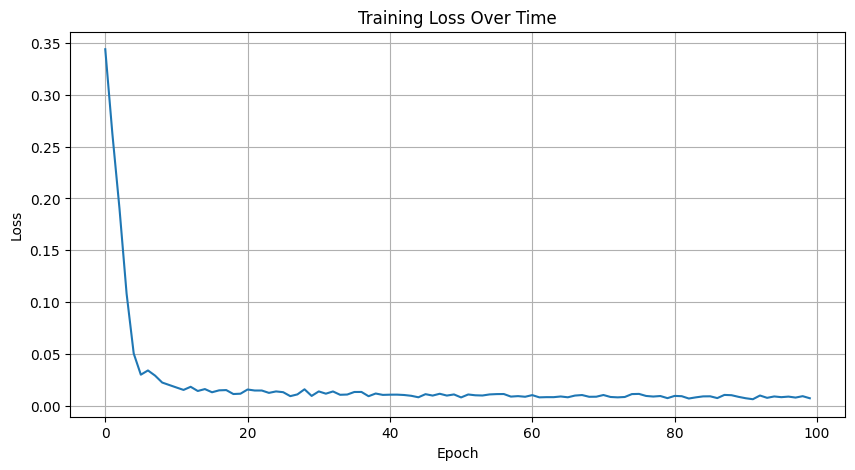

Testing RMSE: 26.95 TWD

Last 5 days comparison:
                       Date  Actual Price  Predicted Price
0 2024-10-21 00:00:00+00:00        1085.0      1043.236572
1 2024-10-22 00:00:00+00:00        1075.0      1049.563721
2 2024-10-23 00:00:00+00:00        1060.0      1056.693970
3 2024-10-24 00:00:00+00:00        1060.0      1042.689575
4 2024-10-25 00:00:00+00:00        1065.0      1046.725586

Test Set Prediction Accuracy: 97.85%


In [12]:
model.eval()
with torch.no_grad():
  train_predict = model(X_train)
  test_predict = model(X_test)

  # 轉換回原始數據尺度
  train_predict = scaler.inverse_transform(train_predict.numpy())
  test_predict = scaler.inverse_transform(test_predict.numpy())
  y_train_orig = scaler.inverse_transform(y_train.numpy())
  y_test_orig = scaler.inverse_transform(y_test.numpy())

# 繪製結果
# 視覺化部分的修改（Cell 5)
plt.figure(figsize=(15, 7))

# 繪製實際數據
plt.plot(data.index[prediction_days:train_size+prediction_days], y_train_orig,
         label='Training Data (True)', color='blue', alpha=0.7)
plt.plot(data.index[train_size+prediction_days:], y_test_orig,
         label='Test Data (True)', color='green', alpha=0.7)

# 只繪製測試集的預測數據
plt.plot(data.index[train_size+prediction_days:], test_predict,
         label='Predicted Price', color='red', linestyle='--', alpha=0.7)

plt.title(f'{stock_id} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (TWD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 顯示訓練過程中的損失變化
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# 計算測試集的預測準確度
test_rmse = np.sqrt(np.mean((test_predict - y_test_orig) ** 2))
print(f'Testing RMSE: {test_rmse:.2f} TWD')

# 顯示最後5天的實際值和預測值比較
last_5_days = pd.DataFrame({
    'Date': data.index[-5:],
    'Actual Price': close_data[-5:].flatten(),
    'Predicted Price': test_predict[-5:].flatten()
})
print("\nLast 5 days comparison:")
print(last_5_days)

# 計算測試集的預測準確率
test_accuracy = 100 - (np.abs(test_predict - y_test_orig) / y_test_orig * 100).mean()
print(f'\nTest Set Prediction Accuracy: {test_accuracy:.2f}%')

### 作業二：使用 TensorFlow 或 PyTorch 實作 CNN 捕捉 K 線趨勢，並預測股價漲跌（分類任務）。
- 說明：輸入一張 N 天的 K 線圖判斷未來價格可能漲或跌，label 方式可以使用技術指標輔助，例如：5日均線高於10日均線標註「漲」，5日均線低於10日均線標註「跌」。

- 載入套件

In [48]:
!pip install mplfinance

In [49]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

- 下載和準備數據

In [50]:
# 股票參數設定
stock_id = "2330.TW"
start_date = "2024-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

# 下載股票資料
df = yf.download(stock_id, start=start_date, end=end_date)

# 確保所有價格數據為float類型
price_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df[price_cols] = df[price_cols].astype(float)

# 計算技術指標
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA10'] = df['Close'].rolling(window=10).mean()
df['Label'] = (df['MA5'] > df['MA10']).astype(int)

# 移除NaN值
df = df.dropna()

# 分割訓練集和測試集 (8:2)
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

[*********************100%***********************]  1 of 1 completed


- 準備序列數據

In [51]:
def create_sequences(data, sequence_length):
  sequences = []
  labels = []

  # 使用開高低收作為特徵
  price_data = data[['Open', 'High', 'Low', 'Close']].values

  for i in range(len(data) - sequence_length):
    seq = price_data[i:(i + sequence_length)]
    label = data['Label'].values[i + sequence_length]
    sequences.append(seq)
    labels.append(label)

  return np.array(sequences), np.array(labels)

# 設定序列長度
sequence_length = 10

# 創建訓練集和測試集序列
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# 標準化數據
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

# 轉換為PyTorch張量
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

- 定義CNN模型

In [52]:
class StockCNN(nn.Module):
  def __init__(self, sequence_length, n_features):
    super(StockCNN, self).__init__()
    self.conv1 = nn.Conv1d(n_features, 64, kernel_size=3)
    self.conv2 = nn.Conv1d(64, 32, kernel_size=3)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool1d(2)
    self.dropout = nn.Dropout(0.25)

    # 計算展平後的特徵數量
    L_out1 = sequence_length - 2  # Conv1d kernel_size=3
    L_out1 = L_out1 // 2  # MaxPool1d
    L_out2 = L_out1 - 2  # Conv1d kernel_size=3
    L_out2 = L_out2 // 2  # MaxPool1d
    self.flatten_features = 32 * L_out2

    self.fc1 = nn.Linear(self.flatten_features, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    x = x.permute(0, 2, 1)
    x = self.relu(self.conv1(x))
    x = self.pool(x)
    x = self.relu(self.conv2(x))
    x = self.pool(x)
    x = self.dropout(x)
    x = x.flatten(1)
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x


- 訓練模型

In [53]:
model = StockCNN(sequence_length=sequence_length, n_features=4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 訓練設置
num_epochs = 50
batch_size = 32
train_loader = DataLoader(list(zip(X_train_tensor, y_train_tensor)),
              batch_size=batch_size, shuffle=True)

# 用於存儲訓練過程
train_losses = []
train_accuracies = []

# 訓練迴圈
for epoch in range(num_epochs):
  model.train()
  total_loss = 0
  correct = 0
  total = 0

  for batch_X, batch_y in train_loader:
    optimizer.zero_grad()
    outputs = model(batch_X)
    loss = criterion(outputs, batch_y)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += batch_y.size(0)
    correct += (predicted == batch_y).sum().item()

  avg_loss = total_loss / len(train_loader)
  accuracy = 100 * correct / total

  train_losses.append(avg_loss)
  train_accuracies.append(accuracy)

  if (epoch + 1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')


Epoch [10/50], Loss: 0.4930, Accuracy: 74.82%
Epoch [20/50], Loss: 0.3916, Accuracy: 80.58%
Epoch [30/50], Loss: 0.3054, Accuracy: 87.05%
Epoch [40/50], Loss: 0.2397, Accuracy: 92.09%
Epoch [50/50], Loss: 0.1660, Accuracy: 94.96%


- 評估和視覺化

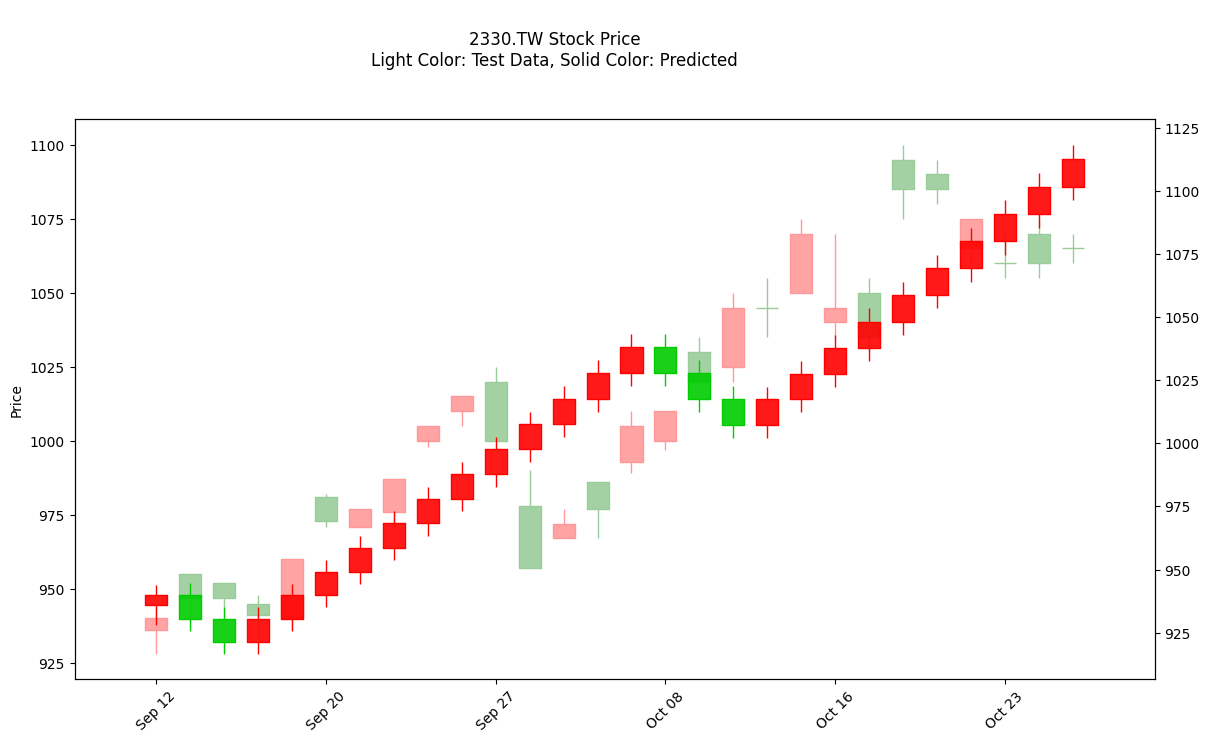


預測準確度: 96.43%

最後一天預測:
實際結果: 漲
預測結果: 漲


In [66]:
# 準備測試數據的K線圖
test_start_idx = train_size + sequence_length
test_plot_data = df[test_start_idx:].copy()

# 重設數據結構
test_plot_data = test_plot_data.reset_index()
test_plot_data.columns = test_plot_data.columns.get_level_values(0)
test_plot_data.set_index('Date', inplace=True)

# 只保留K線圖所需的列
actual_data = test_plot_data[['Open', 'High', 'Low', 'Close']].copy()
pred_data = actual_data.copy()

# 根據預測結果修改預測數據
for i, pred in enumerate(predicted[:-1]):
  current_close = float(pred_data['Close'].iloc[i])
  if pred == 1:  # 預測漲
    pred_data.iloc[i+1, pred_data.columns.get_loc('Open')] = current_close
    pred_data.iloc[i+1, pred_data.columns.get_loc('Close')] = current_close * 1.01
    pred_data.iloc[i+1, pred_data.columns.get_loc('High')] = current_close * 1.015
    pred_data.iloc[i+1, pred_data.columns.get_loc('Low')] = current_close * 0.995
  else:  # 預測跌
    pred_data.iloc[i+1, pred_data.columns.get_loc('Open')] = current_close
    pred_data.iloc[i+1, pred_data.columns.get_loc('Close')] = current_close * 0.99
    pred_data.iloc[i+1, pred_data.columns.get_loc('High')] = current_close * 1.005
    pred_data.iloc[i+1, pred_data.columns.get_loc('Low')] = current_close * 0.985

# 確保所有數據為float類型
for col in ['Open', 'High', 'Low', 'Close']:
  actual_data[col] = actual_data[col].astype(float)
  pred_data[col] = pred_data[col].astype(float)

# 設定實際數據的K線圖樣式（使用淺色）
mc = mpf.make_marketcolors(up='#FF9999',      # 淺紅色
              down='#99CC99',      # 淺綠色
              edge='inherit',
              wick='inherit')
s = mpf.make_mpf_style(marketcolors=mc)

# 添加預測數據作為第二個K線圖（使用深色）
ap = [
  mpf.make_addplot(pred_data,
          type='candle',
          width=0.7,              # 稍微縮小寬度
          marketcolors=mpf.make_marketcolors(
              up='#FF0000',       # 深紅色
              down='#00CC00',     # 深綠色
              edge='inherit',
              wick='inherit'
          ))
]

# 繪製組合圖表
mpf.plot(actual_data,
    type='candle',
    title=f'\n{stock_id} Stock Price\nLight Color: Test Data, Solid Color: Predicted',
    addplot=ap,
    figsize=(15, 8),
    style=s)

# 顯示預測準確度
accuracy = (predicted == y_test_tensor).float().mean().item()
print(f'\n預測準確度: {accuracy*100:.2f}%')

# 顯示最後一天的預測結果
last_actual = "漲" if y_test_tensor[-1] == 1 else "跌"
last_pred = "漲" if predicted[-1] == 1 else "跌"
print(f'\n最後一天預測:')
print(f'實際結果: {last_actual}')
print(f'預測結果: {last_pred}')